In [1]:
import pandas 
%matplotlib inline 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn import feature_selection, preprocessing, pipeline, linear_model, neural_network, model_selection

In [2]:
# begin with the targets 

t = pandas.read_csv('../data_sets/bglb_ML_targets.csv', index_col=0)

# I found that E164D was seriously outlier in
# some of the most-correlated features 
# so removing it 

t = t.drop(['E164D'], axis=0)

t.head()

,kcat,km,kcatkm
mutant_name,,,
S14A,-0.439333,0.217484,-0.651460
T15A,-0.156314,0.025306,-0.176657
S16A,-0.756962,0.447468,-1.199275
S17A,-0.016087,0.567026,-0.577999
S17E,-0.137625,0.165541,-0.298065


In [3]:
t.shape

(110, 3)

In [4]:
# experiemntal highly! # 

# add some nonfunctionals with kcatkms of -5 

In [5]:
! rsync -avz ca:/share/work/alex/bglb_family/rosetta_runs/bglb/enzyme_design/features.h5 .  


rsync: connection unexpectedly closed (0 bytes received so far) [receiver]
rsync error: unexplained error (code 255) at /BuildRoot/Library/Caches/com.apple.xbs/Sources/rsync/rsync-47/rsync/io.c(453) [receiver=2.6.9]


In [6]:
f = pandas.read_hdf('features.h5')
f.shape

(7967, 59)

In [7]:
f.head()

,total_score,fa_rep,hbond_sc,all_cst,tot_pstat_pm,tot_nlpstat_pm,tot_burunsat_pm,tot_hbond_pm,tot_NLconts_pm,tot_nlsurfaceE_pm,...,SR_4_nlpstat_pm,SR_5,SR_5_total_score,SR_5_fa_rep,SR_5_hbond_sc,SR_5_all_cst,SR_5_interf_E_1_2,SR_5_dsasa_1_2,SR_5_hbond_pm,SR_5_burunsat_pm
N1A,-2767.265,434.821,-82.008,0.0,0.659,0.651,164.3,417.5,264.6,4.200,...,0.851,446.0,-7.746,1.909,-2.561,1.353,-11.497,0.890,6.7,0.0
N1C,-2762.902,433.981,-81.513,0.0,0.658,0.651,164.3,417.1,265.0,3.667,...,0.771,446.0,-8.092,1.927,-2.517,1.210,-12.187,0.885,6.4,0.0
N1D,-2765.736,434.348,-81.843,0.0,0.652,0.646,165.5,416.7,265.4,3.605,...,0.830,446.0,-7.659,1.942,-2.574,1.337,-11.321,0.889,5.9,0.0
N1E,-2730.843,434.063,-82.278,0.0,0.646,0.643,164.2,417.9,264.7,3.843,...,0.860,446.0,-8.074,1.935,-2.759,1.113,-12.146,0.890,6.5,0.0
N1F,-2761.816,433.389,-82.594,0.0,0.651,0.645,164.9,417.4,265.2,4.237,...,0.877,446.0,-8.071,1.827,-2.625,0.964,-12.140,0.893,6.5,0.0


In [8]:
f.head()[['SR_4', 'SR_4_total_score', 'SR_4_fa_rep']]

,SR_4,SR_4_total_score,SR_4_fa_rep
N1A,295.0,-5.021,1.055
N1C,295.0,-5.031,1.088
N1D,295.0,-5.064,1.129
N1E,295.0,-5.039,1.108
N1F,295.0,-4.995,1.094


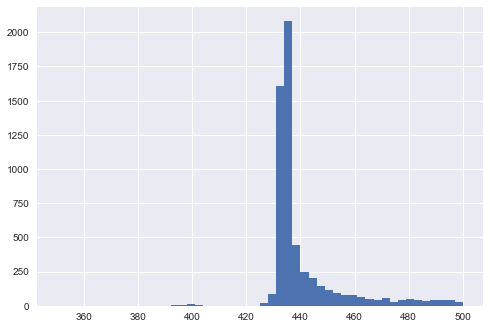

In [9]:
f.fa_rep.hist(bins=50, range=(350, 500))

In [10]:
df = f.join(t).dropna()
df.shape

(105, 62)

In [11]:
# which mutants are not represented in our feature space then? 
[n for n in t.index if n not in df.index]

['BglB', 'A227W', 'X123Y', 'E353E', 'E353E']

In [12]:
# well, good, because those are bullshit 

In [13]:
# lets do the regular descriptive statistics here 

df.describe()

,total_score,fa_rep,hbond_sc,all_cst,tot_pstat_pm,tot_nlpstat_pm,tot_burunsat_pm,tot_hbond_pm,tot_NLconts_pm,tot_nlsurfaceE_pm,...,SR_5_fa_rep,SR_5_hbond_sc,SR_5_all_cst,SR_5_interf_E_1_2,SR_5_dsasa_1_2,SR_5_hbond_pm,SR_5_burunsat_pm,kcat,km,kcatkm
count,105.000000,105.000000,105.000000,105.0,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,...,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000
mean,-2729.695057,443.904091,-81.314395,0.0,0.648085,0.643101,165.045212,416.564471,264.219974,3.694440,...,1.995977,-2.539841,1.782089,-11.120839,0.893501,6.124180,0.058413,-0.757903,0.172661,-0.941951
std,154.602632,43.005378,1.226595,0.0,0.004790,0.004114,1.904045,1.204933,1.359742,0.271939,...,0.114431,0.264081,0.565048,1.079387,0.016227,0.629991,0.236632,0.847189,0.431185,1.068431
min,-2769.558750,428.516000,-83.341000,0.0,0.633000,0.631000,162.100000,412.700000,259.400000,2.507778,...,1.686000,-3.049000,0.557000,-14.405000,0.845556,1.000000,0.000000,-3.643453,-1.096910,-4.044650
25%,-2765.546000,433.287000,-82.088889,0.0,0.645000,0.641000,163.800000,415.900000,263.500000,3.543000,...,1.920000,-2.649000,1.342000,-11.601111,0.888000,6.000000,0.000000,-1.344600,-0.055517,-1.468448
50%,-2763.093333,434.225000,-81.604444,0.0,0.648000,0.644000,164.700000,416.800000,264.500000,3.678000,...,1.998000,-2.555000,1.818000,-11.095000,0.893000,6.200000,0.000000,-0.439333,0.101059,-0.592414
75%,-2759.290000,434.933000,-80.903000,0.0,0.651000,0.646000,166.100000,417.400000,265.125000,3.813000,...,2.052000,-2.500000,2.148000,-10.662222,0.900000,6.400000,0.000000,-0.118408,0.385964,-0.160840
max,-1677.197000,758.247000,-76.900000,0.0,0.663000,0.654000,172.000000,418.625000,266.600000,4.754000,...,2.557000,-0.375000,3.042000,-4.639000,0.947500,7.500000,2.000000,1.097344,1.814514,0.955350


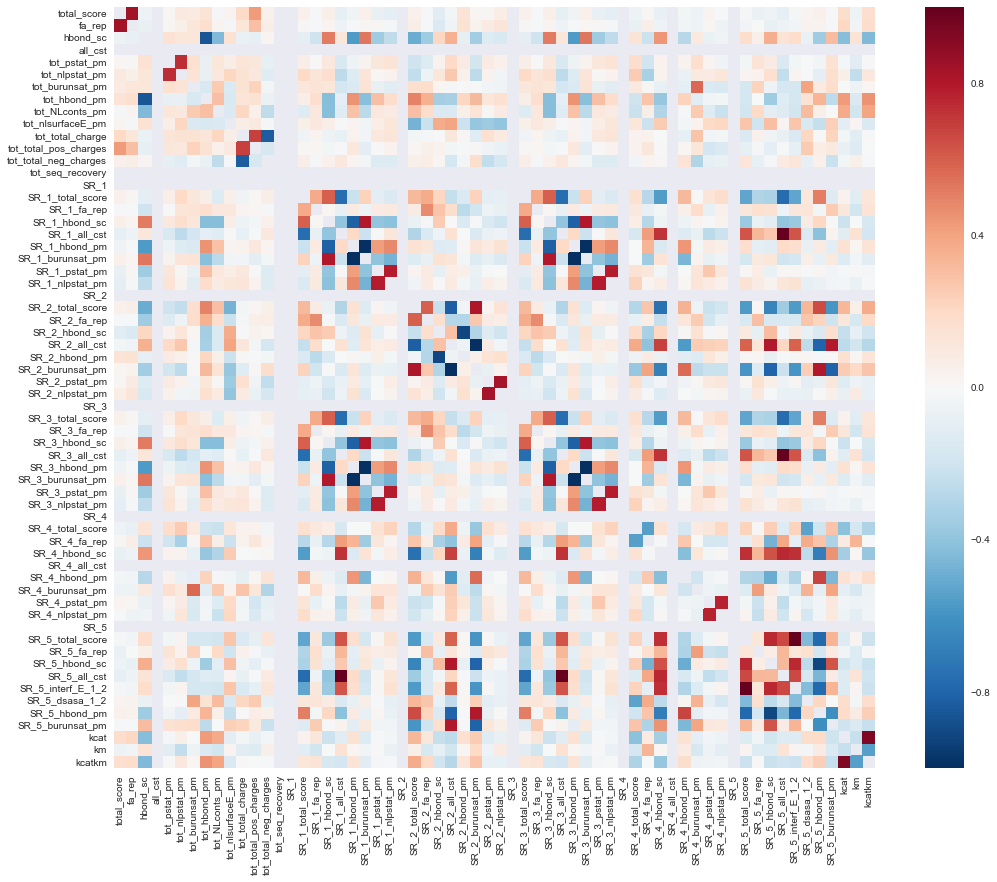

In [14]:
corr = df.corr()
mask = corr < 1

plt.figure(figsize=(18,14))
sns.heatmap(corr.mask(~mask), square=1)

In [15]:
targets = 'kcat km kcatkm'.split()
features = [n for n in df.columns if n not in targets]

In [16]:
# calculate all the individual feature correlations for the Leekasso 
c = corr[targets].dropna().drop(targets, axis=0).sort_values(targets)
c

,kcat,km,kcatkm
hbond_sc,-0.422980,0.134982,-0.445124
SR_4_total_score,-0.407584,-0.172908,-0.308398
SR_4_hbond_sc,-0.340072,0.021108,-0.387414
SR_2_all_cst,-0.260258,-0.194039,-0.284483
SR_2_hbond_sc,-0.238990,-0.088559,-0.203106
SR_1_hbond_sc,-0.213441,-0.003501,-0.167313
SR_3_hbond_sc,-0.213441,-0.003501,-0.167313
SR_5_burunsat_pm,-0.206303,-0.152760,-0.228628
SR_5_hbond_sc,-0.189200,-0.136323,-0.220909
SR_5_total_score,-0.139648,0.028271,-0.215093


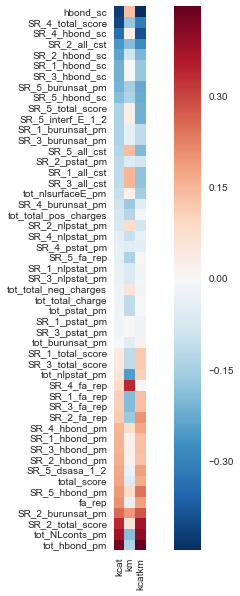

In [17]:
plt.figure(figsize=(10,10))
sns.heatmap(c, square=1)

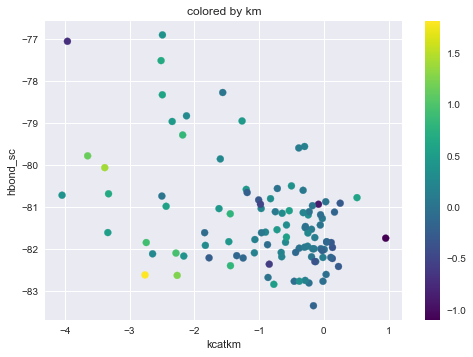

In [18]:
feature = 'hbond_sc'
plt.scatter(df.kcatkm, df[feature], c=df.km, cmap='viridis')
plt.colorbar()
plt.title('colored by km')
plt.xlabel('kcatkm')
plt.ylabel(feature)

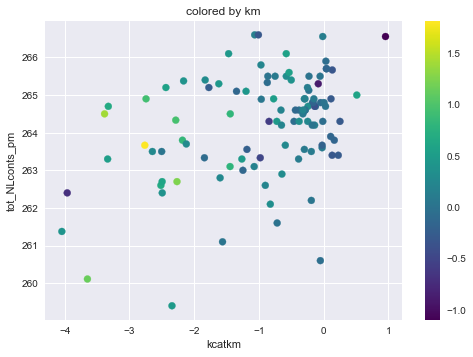

In [19]:
feature = 'tot_NLconts_pm'
plt.scatter(df.kcatkm, df[feature], c=df.km, cmap='viridis')
plt.colorbar()
plt.title('colored by km')
plt.xlabel('kcatkm')
plt.ylabel(feature)

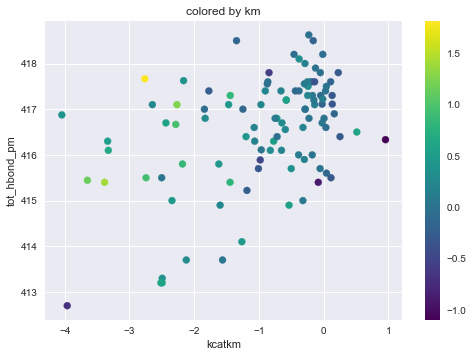

In [20]:
feature = 'tot_hbond_pm'
plt.scatter(df.kcatkm, df[feature], c=df.km, cmap='viridis')
plt.colorbar()
plt.title('colored by km')
plt.xlabel('kcatkm')
plt.ylabel(feature)

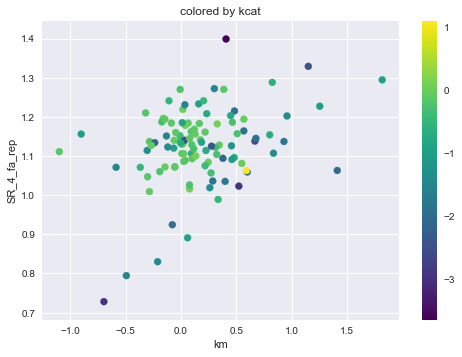

In [21]:
feature = 'SR_4_fa_rep'
plt.scatter(df.km, df[feature], c=df.kcat, cmap='viridis')
plt.colorbar()
plt.title('colored by kcat')
plt.xlabel('km')
plt.ylabel(feature)

In [22]:
#df.query('tot_hbond_pm<408')
# used this to find that E164D was the outlier 

In [24]:
pln = pipeline.Pipeline([
    ('variance', feature_selection.VarianceThreshold()),
    ('scaler', preprocessing.StandardScaler()),
    ('elastic_net', linear_model.ElasticNet()),
#     ('neural_net', neural_network.MLPRegressor()),
#     ('linear_regression', linear_model.LinearRegression()),
])

params = {
    'elastic_net__normalize': [True], 
#     'elastic_net__cv': [2, 5], 
    'elastic_net__l1_ratio': [0.5, 0.9, 0.95, 0.99], 
    'elastic_net__max_iter': [1e4],
    'elastic_net__selection': ['random'],
    'elastic_net__alpha': [10**-n for n in (0,1,2,3)]
}

grid = model_selection.GridSearchCV(pln, params, cv=10, n_jobs=-1)

X = df[features]
y = df['kcat']

grid.fit(X, y)

pred = grid.predict(X)

In [25]:
grid.best_estimator_

Pipeline(steps=[('variance', VarianceThreshold(threshold=0.0)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('elastic_net', ElasticNet(alpha=0.01, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=10000.0, normalize=True, positive=False, precompute=False,
      random_state=None, selection='random', tol=0.0001, warm_start=False))])

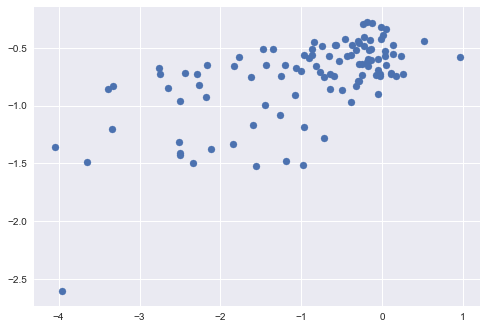

In [26]:
plt.scatter(df.kcatkm, pred)

In [27]:
# now, read in features from another protein 

In [28]:
! rsync -avz ca:/share/work/alex/bglb_family/rosetta_runs/run_A/enzyme_design/features.h5 .  


rsync: connection unexpectedly closed (0 bytes received so far) [receiver]
rsync error: unexplained error (code 255) at /BuildRoot/Library/Caches/com.apple.xbs/Sources/rsync/rsync-47/rsync/io.c(453) [receiver=2.6.9]


In [33]:
p = pandas.read_hdf('features.h5')
p.head()

,total_score,fa_rep,hbond_sc,all_cst,tot_pstat_pm,tot_nlpstat_pm,tot_burunsat_pm,tot_hbond_pm,tot_NLconts_pm,tot_nlsurfaceE_pm,...,SR_4_nlpstat_pm,SR_5,SR_5_total_score,SR_5_fa_rep,SR_5_hbond_sc,SR_5_all_cst,SR_5_interf_E_1_2,SR_5_dsasa_1_2,SR_5_hbond_pm,SR_5_burunsat_pm
N1A,-2767.265,434.821,-82.008,0.0,0.659,0.651,164.3,417.5,264.6,4.200,...,0.851,446.0,-7.746,1.909,-2.561,1.353,-11.497,0.890,6.7,0.0
N1C,-2762.902,433.981,-81.513,0.0,0.658,0.651,164.3,417.1,265.0,3.667,...,0.771,446.0,-8.092,1.927,-2.517,1.210,-12.187,0.885,6.4,0.0
N1D,-2765.736,434.348,-81.843,0.0,0.652,0.646,165.5,416.7,265.4,3.605,...,0.830,446.0,-7.659,1.942,-2.574,1.337,-11.321,0.889,5.9,0.0
N1E,-2730.843,434.063,-82.278,0.0,0.646,0.643,164.2,417.9,264.7,3.843,...,0.860,446.0,-8.074,1.935,-2.759,1.113,-12.146,0.890,6.5,0.0
N1F,-2761.816,433.389,-82.594,0.0,0.651,0.645,164.9,417.4,265.2,4.237,...,0.877,446.0,-8.071,1.827,-2.625,0.964,-12.140,0.893,6.5,0.0


In [30]:
names = pandas.read_csv('../data_sets/names.csv', index_col=0)
names

,1,2,3,4,5,6,7,8,9,10,0.1
0,,,,,,,,,,,
P22505_16,R240A,E222A,Y295W,Q19A,W325A,W120F,Y118F,N293Q,T352V,N220Y,WT
Q7MG41_142,S246R,T230E,Y298W,Q27A,W326A,W128F,Y126F,N296Q,T353V,N223Y,WT
Q97AX4_139,A281R,T264E,Y315W,Q20A,W354A,W150F,Y148F,N313Q,T379V,A262Y,WT
Q59976_4,I241R,H223E,Y295W,Q18A,W342A,W120F,Y118F,N293Q,T368V,N221Y,WT


In [31]:
mut_names = [n for n in list(names.T['Q7MG41_142']) if n != 'WT'] + ['Q27Q']
mut_names

['S246R',
 'T230E',
 'Y298W',
 'Q27A',
 'W326A',
 'W128F',
 'Y126F',
 'N296Q',
 'T353V',
 'N223Y',
 'Q27Q']

In [32]:
mut_feats = p.loc[mut_names].dropna()
mut_feats

KeyError: "None of [['S246R', 'T230E', 'Y298W', 'Q27A', 'W326A', 'W128F', 'Y126F', 'N296Q', 'T353V', 'N223Y', 'Q27Q']] are in the [index]"

In [32]:
pred2 = grid.predict(mut_feats)
pred2

array([-4.17866712, -3.90912777, -4.80494431, -5.43948598, -4.46098595,
       -4.17719709, -4.33299862, -4.36052189])

In [33]:
pred_map = dict(zip(mut_feats.index, pred2))
pred_map

{'N296Q': -4.3329986165585321,
 'Q27A': -4.8049443086955081,
 'S246R': -4.1786671207834756,
 'T230E': -3.9091277737252859,
 'T353V': -4.3605218878898047,
 'W128F': -4.4609859548808206,
 'W326A': -5.4394859767683723,
 'Y126F': -4.1771970862600734}

In [34]:
my_series = names.T['Q7MG41_142']
my_series.index = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 0]

# get the actual values 
data = pandas.read_csv('../data_sets/family_data_set.csv')
s = data[(data.scaffold == 'Q7MG41_142') & (data.kinetic_constant == 'km') & (data.rel_or_abs == 'rel')].copy()
s['mutant'] = s.mutant_name_index.map(my_series)
s['prediction'] = s.mutant.map(pred_map)
s

,value,mutant_name_index,kinetic_constant,rel_or_abs,scaffold,mutant,prediction
133,0.000000,0,km,rel,Q7MG41_142,WT,NaN
136,0.000000,1,km,rel,Q7MG41_142,S246R,-4.178667
139,-0.301030,2,km,rel,Q7MG41_142,T230E,-3.909128
142,-0.477121,3,km,rel,Q7MG41_142,Y298W,NaN
145,-1.327359,4,km,rel,Q7MG41_142,Q27A,-4.804944
148,-1.834103,5,km,rel,Q7MG41_142,W326A,-5.439486
151,-1.088136,6,km,rel,Q7MG41_142,W128F,-4.460986
154,-0.096910,7,km,rel,Q7MG41_142,Y126F,-4.177197
157,-0.778151,8,km,rel,Q7MG41_142,N296Q,-4.332999
160,-0.477121,9,km,rel,Q7MG41_142,T353V,-4.360522


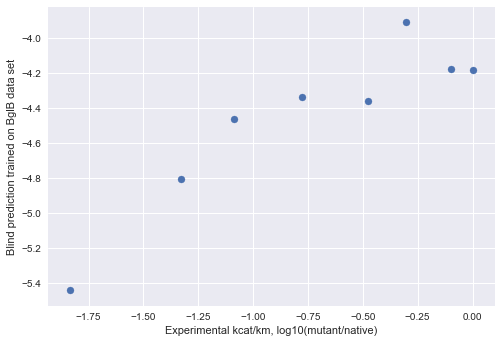

In [35]:
plt.scatter(s.value, s.prediction)
plt.xlabel('Experimental kcat/km, log10(mutant/native)')
plt.ylabel('Blind prediction trained on BglB data set')